In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from typing import List
from matplotlib import pyplot as plt
from moviepy.editor import AudioFileClip
import pylab as pl

In [4]:
import os
import subprocess

def convert_mpg_to_wav(input_folder: str, output_folder: str):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".mpg"):  # Only convert files ending with .mpg
            input_path = os.path.join(input_folder, filename)
            
            # Change the file extension to .wav for the output
            output_filename = os.path.splitext(filename)[0] + ".wav"
            output_path = os.path.join(output_folder, output_filename)

            print(f"Converting {input_path} to {output_path}")

            # Use ffmpeg to convert the file
            try:
                subprocess.run([
                    'ffmpeg', '-i', input_path, '-vn', '-ar', '16000', '-ac', '1', '-c:a', 'pcm_s16le', output_path
                ], check=True)
                print(f"Successfully converted {filename} to {output_filename}")
            except subprocess.CalledProcessError as e:
                print(f"Error converting {filename}: {e}")

# Set the input folder (where the files are located) and output folder
input_folder = r"data\s1"
output_folder = r"data\s11"

# Convert all .mpg files in the input folder
convert_mpg_to_wav(input_folder, output_folder)


Converting data\s1\bbaf2n.mpg to data\s11\bbaf2n.wav


In [3]:
def load_audio(wav_path: str, sr: int = 16000, n_mfcc: int = 75) -> tf.Tensor:
    try:
        # Load the audio file using librosa
        y, sr = librosa.load(wav_path, sr=sr)

        # Extract MFCC features (n_mfcc = number of MFCCs to return)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Compute the mean and standard deviation across the entire dataset
        mean = tf.math.reduce_mean(mfccs)
        std = tf.math.reduce_std(tf.cast(mfccs, tf.float32))

        # Normalize the MFCCs by subtracting the mean and dividing by the standard deviation
        mfccs_normalized = tf.cast((mfccs - mean), tf.float32) / std

        if mfccs.shape[1] == 0:
            raise ValueError(f"Audio file {wav_path} returned empty MFCCs")


        return mfccs_normalized.numpy()
    
    except Exception as e:
        print(f"Error processing audio file: {e}")
        return tf.constant([])  # Return an empty tensor if there's an error

In [4]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [5]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [6]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [7]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [8]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [9]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    audio_path = os.path.join('data','s11',f'{file_name}.wav')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_audio(audio_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

TESTING

In [10]:
test_path = r'.data\s11_converted\bbaf2n.wav'

In [11]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbaf2n'

In [12]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

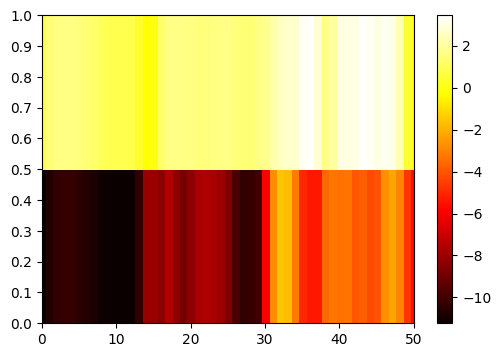

In [27]:
plt.figure(figsize=(6, 4))  # Increase height to stretch the graph vertically
im = plt.imshow(frames, origin="upper", interpolation="nearest", cmap='hot', aspect='auto')
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])  # Set ticks at desired intervals
plt.colorbar(im)
plt.show()

In [13]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23], dtype=int64)>

In [14]:
frames

array([[-11.219836  , -10.680876  , -10.350523  , ..., -10.95119   ,
        -10.596003  ,  -9.97944   ],
       [  0.84456635,   1.379567  ,   1.6134152 , ...,   1.102087  ,
          1.434997  ,   1.8401899 ],
       [  0.7746769 ,   0.9748918 ,   0.9900419 , ...,   0.82484055,
          0.8645659 ,   0.7175677 ],
       ...,
       [  0.04123581,   0.03144116,   0.05488856, ...,   0.05772404,
          0.04253342,   0.05894286],
       [  0.0419609 ,   0.05888664,   0.03699785, ...,   0.04005207,
          0.03577196,   0.0238829 ],
       [  0.04132091,   0.08337635,   0.02712598, ...,   0.01225954,
          0.02566243,   0.02505935]], dtype=float32)

In [15]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [16]:
def mappable_function(path: str) -> List[tf.Tensor]:
    # Use tf.py_function to wrap load_data, specifying the output types
    mfccs, alignment = tf.py_function(load_data, [path], [tf.float32, tf.int64])
    
    # Set the shapes for the output tensors (this is important for batching)
    mfccs.set_shape([None, 13])  # Assuming variable time steps and 13 MFCC features
    alignment.set_shape([None])    # Assuming variable length for alignment

    return mfccs, alignment


PIPELINING

In [17]:
# Assuming mappable_function processes the .mpg files to return audio features
data = tf.data.Dataset.list_files('./data/s11/*.wav')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)  # mappable_function should return the MFCC features

# Update padded_shapes for audio data
# Example: [75, 13] for 75 time steps and 13 MFCC features
data = data.padded_batch(2, padded_shapes=([75, None],[40]))

# Prefetching for performance
data = data.prefetch(tf.data.AUTOTUNE)

# Split the dataset into train and test sets
train = data.take(400)
test = data.skip(400).take(75)

# Optionally, you can uncomment the following lines for a smaller test
# train = data.take(15)
# test = data.skip(15).take(5)

In [18]:
len(test)

75

In [19]:
frames, alignments = data.as_numpy_iterator().next()

In [20]:
# Temporarily remove padding for debugging
for frames, alignments in data.take(10):
    print(f"Frames shape: {frames.shape}")
    print(f"Alignments shape: {alignments.shape}")


Frames shape: (2, 75, 94)
Alignments shape: (2, 40)
Frames shape: (2, 75, 94)
Alignments shape: (2, 40)
Frames shape: (2, 75, 94)
Alignments shape: (2, 40)
Frames shape: (2, 75, 94)
Alignments shape: (2, 40)
Frames shape: (2, 75, 94)
Alignments shape: (2, 40)
Frames shape: (2, 75, 94)
Alignments shape: (2, 40)
Frames shape: (2, 75, 94)
Alignments shape: (2, 40)
Frames shape: (2, 75, 94)
Alignments shape: (2, 40)
Frames shape: (2, 75, 94)
Alignments shape: (2, 40)
Frames shape: (2, 75, 94)
Alignments shape: (2, 40)


In [21]:
len(frames)

2

In [22]:
sample = data.as_numpy_iterator()

In [23]:
val = sample.next(); val[0]

array([[[-1.0719211e+01, -1.0594717e+01, -1.0658310e+01, ...,
         -1.0840042e+01, -1.0856792e+01, -1.0960427e+01],
        [ 9.6765810e-01,  1.1394382e+00,  1.0687348e+00, ...,
          8.3023334e-01,  8.0976206e-01,  6.6846418e-01],
        [ 8.3530217e-01,  9.9340314e-01,  9.7066849e-01, ...,
          7.8953379e-01,  7.7342761e-01,  6.4419496e-01],
        ...,
        [ 2.1130918e-02,  4.8056446e-02,  4.6039611e-02, ...,
          2.7553860e-02,  3.8680878e-02,  2.5926519e-02],
        [ 9.5942914e-03,  3.4343481e-02,  3.6529243e-02, ...,
          3.6284592e-02,  3.9825402e-02,  1.8754810e-02],
        [-3.2286381e-03,  1.6871646e-02,  2.2578973e-02, ...,
          4.1679554e-02,  4.0791959e-02,  1.2417561e-02]],

       [[-1.0658462e+01, -9.5848427e+00, -9.2509556e+00, ...,
         -1.1736258e+01, -1.1426744e+01, -1.0931206e+01],
        [ 1.9267962e+00,  2.0772879e+00,  1.6804192e+00, ...,
          1.3035239e+00,  1.5703542e+00,  1.9207311e+00],
        [ 3.8845247e-01, 

In [24]:
print(val[0].shape)  # This will print the shape of `val`


(2, 75, 94)


In [25]:
array = val[0][1]

# Ensure the array is in uint8 format
if array.dtype != np.uint8:
    array = (255 * (array - np.min(array)) / (np.max(array) - np.min(array))).astype(np.uint8)

print(f"Array shape after conversion: {array.shape}, Array dtype: {array.dtype}")

Array shape after conversion: (75, 94), Array dtype: uint8


PIPELINE-TESTING

In [26]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue with y six now'>

NEURAL NETWORK

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import TimeDistributed, Reshape, Bidirectional, LSTM, Dense, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [65]:
data.as_numpy_iterator().next()[0].shape

(2, 75, 94)

In [66]:
# Define the new model
model = Sequential()

# Convolutional layers
model.add(Conv2D(128, (3, 3), input_shape=(75, 94, 1), padding='same'))  # Input shape adjusted for 2D
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))  # Pooling layer for downsampling

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(75, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))

# Reshape output for LSTM layers
# Reshape to 3D shape (timesteps, features) for LSTM input
model.add(TimeDistributed(Reshape((-1,))))  # Flatten the spatial dimensions

# Bidirectional LSTM layers
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.3))

# Final Dense layer for classification at each time step
model.add(TimeDistributed(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax')))

# Model summary (optional)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 75, 94, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 94, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 94, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 47, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 47, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75, 47, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 75, 47, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 23, 75)     │       172,875 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 75, 23, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 75, 23, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 11, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 75, 825)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 75, 256)        │       976,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 75, 41)         │        10,537 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,852,832 (7.07 MB)

 Trainable params: 1,851,914 (7.06 MB)

 Non-trainable params: 918 (3.59 KB)

In [67]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [68]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b"''izzdd5555555555ooooooooooooooooooooooohhhhhhhhooooooooooooooooooooooooooo">

In [69]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b"''izzdd5555555555ooooooooooooooooooooooohhhhhhhhooooooooooooooooooooooooooo">

In [70]:
model.input_shape

(None, 75, 94, 1)

In [71]:
model.output_shape

(None, 75, 41)

TRAINING

In [72]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1).numpy())
        # return lr * tf.math.exp(-0.1)
        # return lr * 0.5 ** (epoch // 30)

In [73]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [75]:
def CTCAccuracy(y_true, y_pred):
    # Cast to proper types
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    time_steps = tf.cast(tf.shape(y_pred)[1], dtype="int64")

    # Create input lengths for each sample in the batch
    input_length = tf.fill([batch_len], time_steps)

    # Decode predictions using CTC
    decoded_pred, _ = tf.keras.backend.ctc_decode(y_pred, input_length=input_length, greedy=True)
    decoded_pred = decoded_pred[0]  # Get the first decoded output

    # Ensure y_true is in dense format and properly cast
    y_true_dense = tf.cast(y_true, dtype=tf.int64)

    # Get the maximum lengths of true and predicted sequences
    max_len_true = tf.shape(y_true_dense)[1]
    max_len_pred = tf.shape(decoded_pred)[1]

    # Pad or truncate decoded_pred based on its length relative to y_true_dense
    decoded_pred = tf.cond(
        max_len_pred < max_len_true,
        lambda: tf.pad(decoded_pred, [[0, 0], [0, max_len_true - max_len_pred]], constant_values=-1),
        lambda: decoded_pred[:, :max_len_true]
    )

    # Compare the true labels with predicted ones to compute accuracy
    accuracy_per_sample = tf.reduce_mean(
        tf.cast(tf.equal(y_true_dense, decoded_pred), dtype=tf.float32),
        axis=-1  # Compute accuracy along the time step dimension
    )

    # Compute mean accuracy over the batch
    mean_accuracy = tf.reduce_mean(accuracy_per_sample)

    return mean_accuracy


In [76]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        batch_size = tf.shape(yhat)[0].numpy()
        time_steps = tf.shape(yhat)[1]
        input_length = np.full(shape=(batch_size,), fill_value=time_steps)
        # decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        decoded, _ = tf.keras.backend.ctc_decode(yhat, input_length=input_length, greedy=False)
        decoded = decoded[0].numpy()
        for x in range(batch_size):           
            # print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            # print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            # print('~'*100)
            original = tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
            prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
            print(f'Original: {original}')
            print(f'Prediction: {prediction}')
            print('~' * 100)

In [77]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss, metrics=[CTCAccuracy])

In [78]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint1.weights.h5'), monitor='loss', save_weights_only=True) 

In [79]:
schedule_callback = LearningRateScheduler(scheduler)

In [80]:
example_callback = ProduceExample(test)

In [81]:
model.fit(train, validation_data=test, epochs=75, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepms/step - ctc_accuracy: 0.0267 - loss: 94.351
Original: place white in x one soon
Prediction: la e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green by h six please
Prediction: la e e ea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
400/400 ━━━━━━━━━━━━━━━━━━━━ 183s 430ms/step - ctc_accuracy: 0.0267 - loss: 94.3042 - val_ctc_accuracy: 0.0187 - val_loss: 109.8442 - learning_rate: 1.0000e-04
Epoch 2/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step/step - ctc_accuracy: 0.0633 - loss: 62.995
Original: set blue in m nine soon
Prediction: set re t e aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red sp by g two now
Prediction: la e e t e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
400/400 ━━━━━━━━